In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

# 配置搜索路径
sys.path.append("./")
sys.path.append("../")
sys.path.append("../../")
import backtrader as bt
import pandas as pd
import numpy as np
import sqlite3
from Share.database_auto.db_data_downloader.downloader_base import DownloaderBase
import Share.database_auto.database_config as db_config

In [2]:
def get_model_prediction(model_prediction):
    def get_stock_for_buy(group):
        select_n = group.nlargest(5, "label_pred")[['stock_code']]
        return select_n.to_dict("records")

    def get_stock_for_sell(group):
        select_n = group.nsmallest(5, "label_pred")[['stock_code']]
        return select_n.to_dict("records")

    stock_for_buy = model_prediction.groupby("datetime").apply(get_stock_for_buy).to_dict()
    stock_for_sell = model_prediction.groupby("datetime").apply(get_stock_for_sell).to_dict()
    return stock_for_buy, stock_for_sell

In [26]:
def plot_series_dist(series):
    import matplotlib.pyplot as plt
    %matplotlib inline
    data = series
    plt.figure(figsize=(5,5))
    # 使用matplotlib画直方图
    plt.hist(data, bins=60, edgecolor='k', alpha=0.7)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Data')
    plt.show()

In [17]:
BACKTEST_INDEX_SYMBOLS = "000016"  # 【选股】策略的对比基准=指数index，【择时】策略的对比基准=单股自身
# ---- 回归任务
model_pred_df_v5 = pd.read_pickle(f'./backtest_data/test/{BACKTEST_INDEX_SYMBOLS}_2019-01-01_回归任务_v6.pkl')
model_pred_df_v6 = pd.read_pickle(f'./backtest_data/test/{BACKTEST_INDEX_SYMBOLS}_2019-01-01_回归任务_v7.pkl')

In [27]:
diff_value = model_pred_df_v5['label'] - model_pred_df_v5['label_pred']

In [30]:
np.quantile(diff_value, [0.25, 0.75])

array([-0.10118652,  0.10769781])

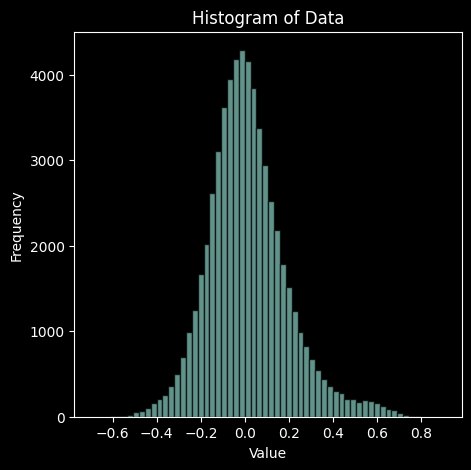

In [28]:
plot_series_dist(diff_value)

In [21]:
# model_pred_df_v5[model_pred_df_v5['datetime'] == '2019-01-02'].sort_values('label_pred', ascending=False).head()

In [22]:
# model_pred_df_v6[model_pred_df_v6['datetime'] == '2019-01-02'].sort_values('label_pred', ascending=False).head()

In [4]:
v5_dict = get_model_prediction(model_pred_df_v5)[0]
v6_dict = get_model_prediction(model_pred_df_v6)[0]

In [6]:
set(v5_dict.keys()).difference(set(v6_dict.keys()))

set()

In [7]:
date_list = list(v5_dict.keys())

In [9]:
date_sample = date_list[1]
print(date_sample)
print(f"v5: {v5_dict[date_sample]}")
print(f"v6: {v6_dict[date_sample]}")

2019-01-03
v5: [{'stock_code': 'sh.603501'}, {'stock_code': 'sh.601633'}, {'stock_code': 'sh.601899'}, {'stock_code': 'sh.600900'}, {'stock_code': 'sh.603799'}]
v6: [{'stock_code': 'sh.601899'}, {'stock_code': 'sh.600150'}, {'stock_code': 'sh.601633'}, {'stock_code': 'sh.600028'}, {'stock_code': 'sh.600436'}]


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_close_label(df, label_name='label'):
    # 设置图像的大小
    plt.figure(figsize=(14, 7))
    # 绘制收盘价曲线
    plt.plot(df['datetime'], df['close'], label='Close Price', color='blue')
    # 提取买入和卖出点
    buy_points = df[df[label_name] == 1]
    sell_points = df[df[label_name] == -1]
    # 在买入点绘制上升三角形标记
    plt.scatter(buy_points['datetime'], buy_points['close'], label='Buy', color='green', marker='^', alpha=1)
    # 在卖出点绘制下降三角形标记
    plt.scatter(sell_points['datetime'], sell_points['close'], label='Sell', color='red', marker='v', alpha=1)
    # 增加标题和标签
    plt.title('Stock Price with Buy and Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    # 显示图例
    plt.legend()
    # 展示图形
    plt.show()

def mark_signals(group):
    top3 = group.nlargest(3, 'label_pred')  # 获取标签预测排名Top 3
    bottom3 = group.nsmallest(3, 'label_pred')  # 获取标签预测排名Bottom 3
    group.loc[top3.index, 'signal'] = 1  # 标记买入点
    group.loc[bottom3.index, 'signal'] = -1  # 标记卖出点
    return group
df = model_pred_df.copy()
df['signal'] = 0
df = df.groupby('datetime').apply(mark_signals)

db_conn = sqlite3.connect("../../Share/database_auto/hh_quant_auto.db")
db_downloader = DownloaderBase(db_conn=db_conn, db_config=db_config)

In [4]:
df[['stock_code', 'stock_name']].drop_duplicates().to_dict('records')

[{'stock_code': 'sh.688111', 'stock_name': '金山办公'},
 {'stock_code': 'sh.688599', 'stock_name': '天合光能'},
 {'stock_code': 'sh.688981', 'stock_name': '中芯国际'},
 {'stock_code': 'sh.600905', 'stock_name': '三峡能源'},
 {'stock_code': 'sh.601728', 'stock_name': '中国电信'},
 {'stock_code': 'sh.688041', 'stock_name': '海光信息'},
 {'stock_code': 'sh.603259', 'stock_name': '药明康德'},
 {'stock_code': 'sh.603501', 'stock_name': '韦尔股份'},
 {'stock_code': 'sh.603986', 'stock_name': '兆易创新'},
 {'stock_code': 'sh.601988', 'stock_name': '中国银行'},
 {'stock_code': 'sh.601601', 'stock_name': '中国太保'},
 {'stock_code': 'sh.600150', 'stock_name': '中国船舶'},
 {'stock_code': 'sh.601390', 'stock_name': '中国中铁'},
 {'stock_code': 'sh.600089', 'stock_name': '特变电工'},
 {'stock_code': 'sh.600050', 'stock_name': '中国联通'},
 {'stock_code': 'sh.600406', 'stock_name': '国电南瑞'},
 {'stock_code': 'sh.600111', 'stock_name': '北方稀土'},
 {'stock_code': 'sh.601919', 'stock_name': '中远海控'},
 {'stock_code': 'sh.600900', 'stock_name': '长江电力'},
 {'stock_cod

In [10]:
# sample_pred

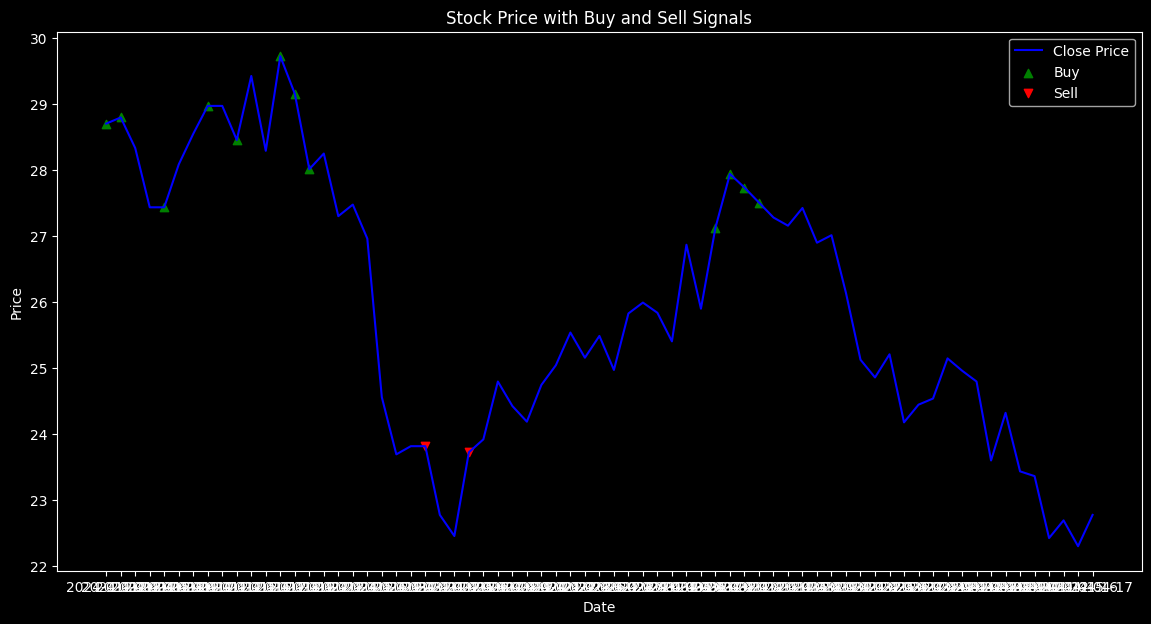

In [6]:
sample_stock_code = 'sh.688599'
sample_pred = df[df['stock_code'] == sample_stock_code]
sample_history = db_downloader._download_history_base_info(sample_stock_code, '2024-01-01', '2024-12-31')
sample_merge = sample_pred.merge(sample_history, left_on=['stock_code', 'datetime'], right_on=['code', 'datetime'])

plot_close_label(sample_merge, 'signal')

[1, 2, 3]